#   Implementation of genetic algorithm
##  Features
-   any number of parameters
-   any aoi (area of interest)
-   any function
-   visualisation


### Function to test

\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}


In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [53]:
class Chromosome:
  def __init__(self, length, array=None):
    self.length = length
    self.array = array if array is not None else np.random.randint(2, size=length)

  def decode(self, lower_bound, upper_bound, aoi):
    return min_max_norm(int(''.join(map(str, self.array[lower_bound:upper_bound])), 2), 0, 2**(upper_bound-lower_bound) - 1, aoi[0], aoi[1])

  def mutation(self, probability):
    if np.random.rand() < probability:
      idx = np.random.randint(self.length)
      self.array[idx] = 1 - self.array[idx]

  def crossover(self, other):
    idx = np.random.randint(self.length)
    return Chromosome(self.length, np.concatenate((self.array[:idx], other.array[idx:])))

In [54]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30, verbose=False):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.population_size = population_size
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.verbose = verbose

  def eval_objective_func(self, chromosome):
    part = int(self.chromosome_lengths / self.obj_func_num_args)
    return self.objective_function(*[chromosome.decode(i * part, (i + 1) * part, self.aoi[i]) for i in range(self.obj_func_num_args)])

  def tournament_selection(self):
    tournament = np.random.choice(self.population, self.tournament_size, replace=False)
    return min(tournament, key=self.eval_objective_func)

  def reproduce(self, parents):
    if np.random.rand() < self.crossover_probability:
      return parents[0].crossover(parents[1])
    return parents[0]

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = self.objective_function(X, Y)
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    self.population = [Chromosome(self.chromosome_lengths) for _ in range(self.population_size)]
    trace = []

    for i in range(self.num_steps):
      new_population = []
      best_solution = None

      for _ in range(self.population_size):
        parents = [self.tournament_selection() for _ in range(2)]
        child = self.reproduce(parents)
        child.mutation(self.mutation_probability)

        # Evaluate and save best solution of this generation
        if not best_solution or self.eval_objective_func(child) < self.eval_objective_func(best_solution):
            best_solution = child
        
        new_population.append(child)
      
      if self.verbose:
        print(f"{i}. Best solution: {best_solution.array} with value: {self.eval_objective_func(best_solution)}")
      trace.append([best_solution.decode(i * self.bits_per_arg, (i + 1) * self.bits_per_arg, self.aoi[i]) for i in range(self.obj_func_num_args)])
      self.population = new_population
    self.plot_func(trace)
  
  def set_population_size(self, population_size):
    self.population_size = population_size
  
  def set_mutation_probability(self, mutation_probability):
    self.mutation_probability = mutation_probability
  
  def set_crossover_probability(self, crossover_probability):
    self.crossover_probability = crossover_probability

  def set_num_steps(self, num_steps):
    self.num_steps = num_steps

# Function and its visualisation

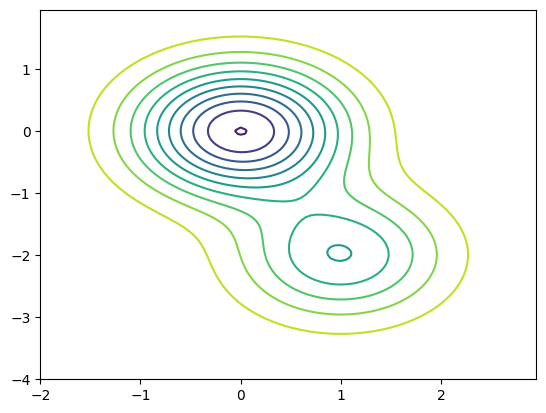

In [55]:
function = lambda x, y: 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))
X = np.arange(-2, 3, 0.05)
Y = np.arange(-4, 2, 0.05)
X, Y = np.meshgrid(X, Y)
Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
plt.figure()
plt.contour(X, Y, Z, 10)
plt.show()

# Test for small pop and number of steps

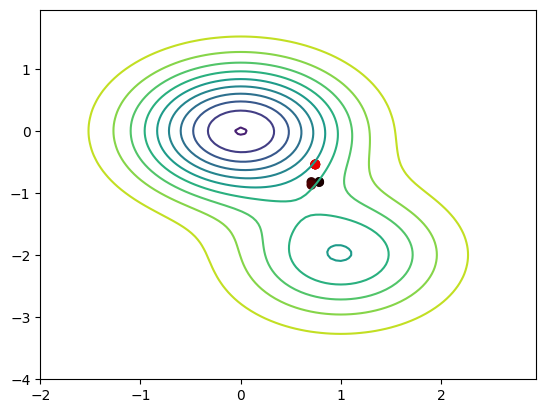

In [56]:
algorithm = GeneticAlgorithm(chromosome_length=16,
                                obj_func_num_args=2,
                                objective_function=function,
                                aoi=[(-2, 3), (-4, 2)],
                                population_size=5,
                                tournament_size=2,
                                mutation_probability=0.5,
                                crossover_probability=0.8,
                                num_steps=10)

algorithm.run()

#   Conclusion:

A small population means a lower probability that any of the initially generated chromosomes will be close to the minimum point. At the same time, a small number of steps means that they won't have enough time to mutate and crossover in a way that would allow them to approach the minimum.

# Test for a bigger number of steps

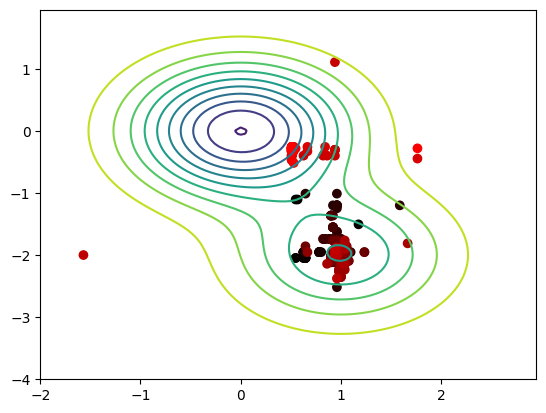

In [57]:
algorithm.set_num_steps(300)
algorithm.run()

#   Conclusion
With the increase of the number of steps, later generations come close to the minimum

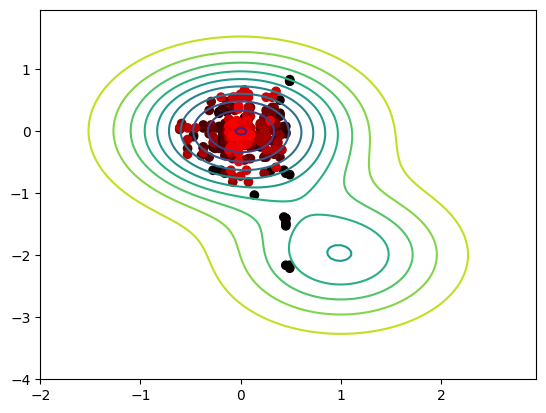

In [58]:
algorithm.set_mutation_probability(1)
algorithm.set_crossover_probability(1)
algorithm.run()

#   Conclusion
Increasing the probability of mutation and crossover, on the other hand, leads to greater chaos — points close to the optimal have a higher chance of mutating or mixing with others, potentially causing it to move away from minimum

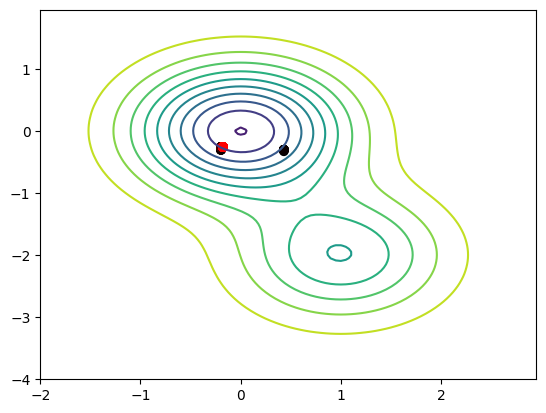

In [59]:
algorithm.set_mutation_probability(0.01)
algorithm.run()

#   Conclusion
A significant decrease in the mutation probability drastically reduces the algorithm's effectiveness.

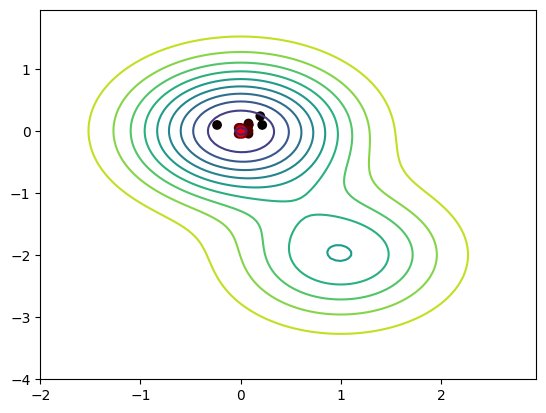

In [60]:
algorithm.set_population_size(100)
algorithm.set_num_steps(30)
algorithm.set_crossover_probability(0.8)
algorithm.set_mutation_probability(0.5)
algorithm.run()

#   Conclusion
The optimal solution in terms of efficiency/time seems to be one with a large population and a small number of steps.

#   Summary:

-    The genetic algorithm, compared to the gradient descent method, has a greater chance of finding the global extremum — at least with a large population.
-    The gradient descent method works faster.
-    The genetic algorithm does not require differentiability of the function and works for discrete functions.
-    Although it more frequently finds the global extremum, it does so with lower accuracy.
##  The genetic algorithm is more effective in solving more complex functions and problems, such as when the function has many extrema.